In [78]:
import sys
sys.path.append('..')

# Drug Discovery Process

---

We're ready to start developing our drug discovery platform. In our previous session, we learned to create simple ADMET predictors. We trained a solubility prediction model (regression) and a blood-brain barrier permeability prediction model (classification). This week, we will download activity data to train a ligand-based model for activity prediction. This model will help us discover hits that bind to our target, which is the first step in the drug design process.

![drug discovery process overview](mldd_diagram_lab2.png)

# Key Molecular Properties in Drug Design

---

Drug design is a process that needs to take into accounts multiple parameters. First, the molecule needs to be of course active, i.e. interact with its biological target to induce some therapeutic effect. Second, this molecule should also have a set of other desirable molecular properties that are known under the term ADMET (absorption, distribution, metabolism, excretion, and toxicity). These properties ensure that our compound will reach its target and will not induce any side effects.

## Activity

Biological activity of a compound is measured in a laboratory by conducting biological **assays** that tests how well our molecule binds and interacts with its biological target. An assay can be done using proteins or whole cells, and there are many types of activity measurements that can be done. For example, we can test only if the molecule binds to its target or look for a specific interaction that causes a desirable effect or inhibition. The activity values are usually expressed as:

- **EC$_{50}$**/**IC$_{50}$** - molecule concentration at which half of the effect or inhibition (blockage) is reached; the lower this value is, the stronger the effect induced by the molecule is.
- **Ki** - the inhibition constant, which measures the binding affinity; again, lower values correspond to stronger binding.
- **Inhibition in %** - the percentage of inhibited proteins.

Oftentimes, XC$_{50}$ and Ki values are converted to the negative logarithmic scale. This is denoted by the letter "*p*" in front of the activity type. This operation reduces the impact of extremely high values. After this transformation, higher values correspond to stronger activity.

For example, pIC$_{50}$ = $-\log_{10} $ IC$_{50}$.


## ADMET

There are myriads of chemical properties that can be measured to ensure the success of our molecule. Depending on the drug target, we might want to optimize different ADMET properties. If our drug needs to work in the central nervous system, we need to check the **blood-brain barrier permeability**. Other drugs that are administered orally need to **absorbed in the intestine**. Our molecule needs to be **metabolically stable**, which means it is not metabolized before it reaches its destination. On the other hand, we need to make sure it is finally metabolized and does not accumulate in the organism. Eventually, drugs can not be **toxic** or induce any serious side effects by interacting with other biological targets (**off-targets**). This is a difficult property to optimize as toxicity is a non-specific property - there are many possible interactions that can cause toxicity, e.g. **hERG inhibition** leads to severe cardiotoxicity (blocked potassium ion channels will cause heart failure).

---

<div style="display: flex; justify-content: space-between">
    <div style="width: 20%; display: inline-block; margin: 20px">
        <img src="../../assets/profile4.png" width="100%">
    </div>
    <div style="width: 60%; display: inline-block; margin: 20px">
        <p><strong>Ami:</strong> Hello there! As a biologist specializing in biochemical assays, I'm excited to explain the crucial process of measuring IC50 and Ki values for compound potency and binding affinity. In our experiments, we meticulously design microplate assays, preparing compound solutions across various concentrations, including controls, and incubating them with our target enzymes, proteins, or receptors. We employ diverse assay types tailored to our targets' nature, such as enzyme inhibition assays, receptor binding assays, and cell-based assays. Following incubation, we measure activity readouts like enzyme activity or fluorescence. IC50 values are determined by analyzing dose-response curves generated from the measured data, typically through nonlinear regression, pinpointing the concentration at which 50% inhibition occurs, crucial for understanding a compound's efficacy and mechanism of action in drug development.</p>
    </div>
</div>
<div style="width: 80%; display: block; margin: 0 20px 0">
    <p>When setting up a compound screening experiment, careful plate design is crucial for accurate and reliable results. Each plate should include compound solutions at various concentrations, along with positive and negative controls to validate assay performance. Replicates of each condition and technical controls help assess experimental variability and ensure data robustness. Randomizing the placement of compounds and controls across the plate minimizes systematic errors, while avoiding edge effects maintains consistency. Documenting the plate layout meticulously facilitates data analysis. Pilot experiments optimize assay conditions and confirm sensitivity. Quality control measures ensure assay reliability throughout the screening process. This comprehensive approach enhances the efficiency and reliability of compound screening experiments, guiding successful drug discovery endeavors.</p>
    </div>

---

# ChEMBL

[ChEMBL](https://www.ebi.ac.uk/chembl/) is a public database of bioactive compounds. The experimentally measured data points are gathered here and they can be used to train machine learning models. It should be noted that this database is manually curated, and the data is pulled from publications and patents. The quality of this data is not always perfect, and the same compound can have multiple drastically different activity values depending on the site the experiments were conducted in. Sometimes these values can contain errors, either caused by humans or incorrect parsing of source documents.

![assay](https://upload.wikimedia.org/wikipedia/commons/thumb/a/a0/96_well_plate.jpg/1599px-96_well_plate.jpg)

Activity data extracted from ChEMBL can be used to train ML models. Because we use the structural information (fingerprints or molecular graphs), these models are also called **QSAR models**, where QSAR stands for Quantitative Structure-Activity Relationship.

**Exercise 1.** Choose one of the targets below and download activity data for this target from ChEMBL. Use one of the activity types (e.g. Ki or IC$_{50}$) to train an ML model. Split the data and print the results of evaluation on the testing set.

- MAO-B (monoamine oxidase B) - its inhibitors can be used to treat symptoms of Parkinson's disease
- ACE2 (angiotensin-converting enzyme 2) - serves as an entry point for SARS-CoV-2
- COX-2 (cyclooxygenase 2) - the taget of non-steroidal anti-inflammatory drugs
- 5-HT3 (serotonin receptor 3) - common target of antiemetics (drugs against vomiting nad nausea)
- hERG - potassium ion channel that is often connected to cardiotoxicity (when inhibited)

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem

In [80]:
pd.set_option('display.max_columns', None)
data_path = "./mao-B-data.csv"  # TODO: You should change this
df = pd.read_csv(data_path, sep=';')
df.head()

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,Standard Value,Standard Units,pChEMBL Value,Data Validity Comment,Comment,Uo Units,Ligand Efficiency BEI,Ligand Efficiency LE,Ligand Efficiency LLE,Ligand Efficiency SEI,Potential Duplicate,Assay ChEMBL ID,Assay Description,Assay Type,BAO Format ID,BAO Label,Assay Organism,Assay Tissue ChEMBL ID,Assay Tissue Name,Assay Cell Type,Assay Subcellular Fraction,Assay Parameters,Assay Variant Accession,Assay Variant Mutation,Target ChEMBL ID,Target Name,Target Organism,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties,Action Type
0,CHEMBL454487,NaN,NaN,236.27,0.0,3.42,11,O=C(Nc1ccccc1)c1cc2ccccc2[nH]1,Ki,'=',230.00,nM,6.64,NaN,NaN,UO_0000065,28.1,0.5,3.22,14.79,0,CHEMBL988018,Inhibition of bovine brain mitochondrial MAO-B...,B,BAO_0000019,assay format,Bos taurus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHEMBL2756,Monoamine oxidase B,Bos taurus,SINGLE PROTEIN,CHEMBL1142552,1,Scientific Literature,Bioorg Med Chem,2008,NaN,NaN,NaN
1,CHEMBL3350682,NaN,NaN,215.34,0.0,3.45,5 (RS),CC=C=CCN(C)C[C@@H](C)c1ccccc1,Ki,'=',690000.00,nM,NaN,Outside typical range,NaN,UO_0000065,NaN,NaN,NaN,NaN,0,CHEMBL729339,In vitro inhibition of bovine monoamine oxidas...,B,BAO_0000357,single protein format,Bos taurus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHEMBL2756,Monoamine oxidase B,Bos taurus,SINGLE PROTEIN,CHEMBL1124175,1,Scientific Literature,J Med Chem,1988,NaN,NaN,NaN
2,CHEMBL522,BENZYLAMINE,NaN,107.16,0.0,1.15,benzylamine,NCc1ccccc1,TN,'=',283.00,M min-1 M-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,CHEMBL709704,Turnover number (TN) for bovine mono-amine oxi...,B,BAO_0000357,single protein format,Bos taurus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHEMBL2756,Monoamine oxidase B,Bos taurus,SINGLE PROTEIN,CHEMBL1127689,1,Scientific Literature,J Med Chem,1994,NaN,NaN,NaN
3,CHEMBL303817,NaN,NaN,302.33,0.0,2.89,3,CN1CC=C(c2c[nH]c3ccccc23)CC1.O=C(O)C(=O)O,Vmax,'=',358.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,CHEMBL732520,Tested for maximum velocity of monoamine oxida...,B,BAO_0000357,single protein format,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHEMBL2756,Monoamine oxidase B,Bos taurus,SINGLE PROTEIN,CHEMBL1130072,1,Scientific Literature,J Med Chem,1997,NaN,NaN,NaN
4,CHEMBL58842,NaN,NaN,249.36,0.0,4.09,30,C1=C(c2ccc3ccccc3c2)CCN(C2CC2)C1,K inact,'=',0.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,CHEMBL730190,Tested for inactivation rate against monoamine...,B,BAO_0000357,single protein format,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHEMBL2756,Monoamine oxidase B,Bos taurus,SINGLE PROTEIN,CHEMBL1130072,1,Scientific Literature,J Med Chem,1997,NaN,NaN,NaN


In [81]:
activity_type = 'IC50'  # TODO: You can change this
# activity_type = 'Inhibition'  # TODO: You can change this
relevant_columns = ['Molecule ChEMBL ID', 'Molecule Name', 'Molecular Weight', '#RO5 Violations', 'Smiles',
                    'Standard Value', 'Standard Units', 'pChEMBL Value']
df = df[(df['Standard Type'] == activity_type) & (df['Standard Relation'].str.contains('='))][relevant_columns]
df


,Molecule ChEMBL ID,Molecule Name,Molecular Weight,#RO5 Violations,Smiles,Standard Value,Standard Units,pChEMBL Value
20,CHEMBL3278797,NaN,222.24,0.0,COC(=O)[C@H](C)NC(=O)c1ccccc1N,410000.0,nM,NaN
21,CHEMBL3585835,NaN,396.44,0.0,COC(=O)CCCCCN1C(=O)c2ccccc2NC1c1ccc2c(c1)OCO2,820000.0,nM,NaN
22,CHEMBL3585836,NaN,386.88,0.0,COC(=O)CCCCCN1C(=O)c2ccccc2NC1c1ccc(Cl)cc1,290000.0,nM,NaN
23,CHEMBL3585833,NaN,368.39,0.0,COC(=O)CCCN1C(=O)c2ccccc2NC1c1ccc2c(c1)OCO2,660000.0,nM,NaN
31,CHEMBL218323,NaN,289.17,1.0,Clc1ccc(-c2cc(-c3ccc(Cl)cc3)[nH]n2)cc1,6025.6,nM,5.22
...,...,...,...,...,...,...,...,...
877,CHEMBL3408925,NaN,441.45,0.0,O=C(Cn1c(=O)c(Cc2ccccc2)nc2ccccc21)N/N=C/c1ccc...,84000.0,nM,4.08
878,CHEMBL3408927,NaN,437.46,0.0,O=C(Cn1c(=O)c(Cc2ccccc2)nc2ccccc21)N/N=C1/C(=O...,96000.0,nM,4.02
879,CHEMBL3408917,NaN,643.74,2.0,CC(C)CC(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)NNC(...,840000.0,nM,NaN
885,CHEMBL8706,CLORGILINE,272.18,0.0,C#CCN(C)CCCOc1ccc(Cl)cc1Cl,9400000.0,nM,NaN


In [82]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2)
len(df_train), len(df_test)

(104, 27)

In [83]:
from rdkit.Chem import DataStructs

class Featurizer:
    def __init__(self, y_column, smiles_col='Drug', **kwargs):
        self.y_column = y_column
        self.smiles_col = smiles_col
        self.__dict__.update(kwargs)

    def __call__(self, df):
        raise NotImplementedError()


class CustomFeaturizer(Featurizer):
    def __init__(self, y_column, radius=2, length=1024, **kwargs):
        self.radius = radius
        self.length = length
        super().__init__(y_column, **kwargs)

    def __call__(self, df):
        features = []
        labels = []
        for i, row in df.iterrows():
            # print(row)
            y = row[self.y_column]
            smiles = row[self.smiles_col]
            mol = Chem.MolFromSmiles(smiles)
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, self.radius, nBits=self.length)

            array = np.zeros((0, ), dtype=np.int8)
            DataStructs.ConvertToNumpyArray(fp, array)
            np.append(array, [mol.GetNumAtoms(),mol.GetNumBonds()])

            features.append(array)
            labels.append(y)

        fingerprints = np.array(features)
        labels = np.array(labels)
        # print("fig: ", fingerprints.shape)
        # print("labels: ", labels.shape)
        return fingerprints, labels

In [84]:
# TODO: Use your training script

from sklearn.ensemble import RandomForestRegressor


featurizer = CustomFeaturizer(y_column="Molecular Weight", smiles_col="Smiles")
X_train, y_train = featurizer(df_train)
X_test, y_test = featurizer(df_test)

model = RandomForestRegressor()
model.fit(X_train, y_train)
model.score(X_test, y_test)

fig:  (104, 1024)
labels:  (104,)
fig:  (27, 1024)
labels:  (27,)


0.9329245848989346

If you want to automate your data pipelines, you can use the ChEMBL Python API, as shown in the example below.

In [85]:
from chembl_webresource_client.new_client import new_client
from tqdm.notebook import tqdm

target = new_client.target
activity = new_client.activity
bace = target.filter(pref_name__iexact='Beta secretase 2').only('target_chembl_id')[0]
activities_provider = activity.filter(target_chembl_id=bace['target_chembl_id']).filter(standard_type="IC50")
activities = list(tqdm(activities_provider))
df_bace = pd.DataFrame.from_records(activities)

  0%|          | 0/1016 [00:00<?, ?it/s]

In [86]:
molecule = new_client.molecule
compounds_provider = molecule.filter(
    molecule_chembl_id__in=list(df_bace["molecule_chembl_id"])
).only("molecule_chembl_id", "molecule_structures")
compounds = list(tqdm(compounds_provider))
df_cmpds = pd.DataFrame.from_records(compounds)
print(f"DataFrame shape: {df_cmpds.shape}")

  0%|          | 0/945 [00:00<?, ?it/s]

DataFrame shape: (945, 2)


**(optional) Excercise 1.1.** *(advanced data splitting methods)*

You might be surprised how good results you can achieve using a random data split. The model performance measured this way can be misleading as ChEMBL contains many similar compounds, series of compounds containing the same scaffold, or even duplicated records. Thus, a better form of evaluation would be to employ a more advanced splitting method, e.g. **scaffold-based split** in which all compounds containing the same scaffold are put in the same set. Another option is to use a **time-based split** because most records in ChEBML should be tagged with the date of their publication. 

Don't be discouraged by the lower results you obtain with these splits. By evaluating your model this way, you get more realistic scores that better reflect the future use cases of your model. The fact that lower evaluation scores may correspond to a better model is known as the **Kubinyi paradox**.

You can now implement a more advanced data split and compare the prediction results on the testing set.

In [87]:
# TODO repeat training with scaffold/time/clustering-based split

**(optional) Excercise 1.2.** *(label transformations)*

As mentioned above, using the logarithmic values can improve the prediction results by eliminating extreme values. Another option is to transform continuous measurements into binary classes, where active compounds are those with IC$_{50}$/Ki values below a certain treshold, and the rest is assumed inactive. This approach can also help dealing with inaccurate noisy measurements.

Try to convert labels into pIC$_{50}$/pKi values or change the regression task to a binary classification problem.

In [88]:
activity_threshold = 100
df['class'] = (df['Standard Value'] <= activity_threshold).astype(int)
df

,Molecule ChEMBL ID,Molecule Name,Molecular Weight,#RO5 Violations,Smiles,Standard Value,Standard Units,pChEMBL Value,class
20,CHEMBL3278797,NaN,222.24,0.0,COC(=O)[C@H](C)NC(=O)c1ccccc1N,410000.0,nM,NaN,0
21,CHEMBL3585835,NaN,396.44,0.0,COC(=O)CCCCCN1C(=O)c2ccccc2NC1c1ccc2c(c1)OCO2,820000.0,nM,NaN,0
22,CHEMBL3585836,NaN,386.88,0.0,COC(=O)CCCCCN1C(=O)c2ccccc2NC1c1ccc(Cl)cc1,290000.0,nM,NaN,0
23,CHEMBL3585833,NaN,368.39,0.0,COC(=O)CCCN1C(=O)c2ccccc2NC1c1ccc2c(c1)OCO2,660000.0,nM,NaN,0
31,CHEMBL218323,NaN,289.17,1.0,Clc1ccc(-c2cc(-c3ccc(Cl)cc3)[nH]n2)cc1,6025.6,nM,5.22,0
...,...,...,...,...,...,...,...,...,...
877,CHEMBL3408925,NaN,441.45,0.0,O=C(Cn1c(=O)c(Cc2ccccc2)nc2ccccc21)N/N=C/c1ccc...,84000.0,nM,4.08,0
878,CHEMBL3408927,NaN,437.46,0.0,O=C(Cn1c(=O)c(Cc2ccccc2)nc2ccccc21)N/N=C1/C(=O...,96000.0,nM,4.02,0
879,CHEMBL3408917,NaN,643.74,2.0,CC(C)CC(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)NNC(...,840000.0,nM,NaN,0
885,CHEMBL8706,CLORGILINE,272.18,0.0,C#CCN(C)CCCOc1ccc(Cl)cc1Cl,9400000.0,nM,NaN,0


In [89]:
# TODO: classification setup

**(optional) Excercise 1.3.** *(exploratory data analysis, data filtering)*

Can you find any discrepancies in the data? For example, do you find any outliers or duplicated SMILES strings? Can you solve these problems?

In [90]:
# Hint: A dot in the SMILES string indicates multiple compounds (this is a separator)
df[df.Smiles.str.contains('\.')]

# TODO: Perform Exploratory Data Analysis

,Molecule ChEMBL ID,Molecule Name,Molecular Weight,#RO5 Violations,Smiles,Standard Value,Standard Units,pChEMBL Value,class
397,CHEMBL3415444,NaN,476.76,0.0,CCOC(=O)C(C(=O)N/N=C/c1ccc(Cl)cc1)[n+]1ccc2ccc...,360000.0,nM,NaN,0
398,CHEMBL3415443,NaN,487.31,0.0,CCOC(=O)C(C(=O)N/N=C/c1ccc([N+](=O)[O-])cc1)[n...,7400000.0,nM,NaN,0


# ZINC

[ZINC](https://zinc.docking.org/) is a database of commercially available compounds. This data can be used for **virtual screening**, i.e. finding active molecules using only *in silico* (computer) methods. These compounds can be then purchased and tested *in vitro* (in cells or biomolecules) or *in vivo* (in living organisms).

---

<div style="display: flex; justify-content: space-between">
    <div style="width: 20%; display: inline-block; margin: 20px">
        <img src="../../assets/profile1.png" width="100%">
    </div>
    <div style="width: 60%; display: inline-block; margin: 20px">
        <p><strong>Nitro:</strong> Hi there! In hit discovery, high-throughput screening plays a crucial role by swiftly evaluating vast compound libraries for potential drug candidates. Molecules for screening can be sourced from diverse sources such as chemical libraries, natural products, or even synthesized compounds. In high-throughput experiments utilizing commercially available compound libraries, thousands to millions of compounds are screened simultaneously against a specific biological target. Typically, automated robotic systems handle the process, dispensing small volumes of compounds into assay plates containing the target of interest. These assays are designed to detect interactions between the compounds and the target, such as binding or inhibition. Following incubation, the plates are analyzed using various detection methods, such as fluorescence, luminescence, or absorbance, to identify hits. Hits are compounds that exhibit the desired activity or effect on the target. These experiments enable rapid screening of immense compound libraries, accelerating the hit discovery process in drug development.</p>
    </div>
</div>
<div style="width: 80%; display: inline-block; margin: 0 20px 0">
        <p>Techniques like DNA-Encoded Libraries (DELs), fragment-based screens, and phenotypic screens offer distinct approaches to identify hits. DELs enable rapid screening of extensive compound collections with unique DNA tags, while fragment-based screens focus on identifying small, low molecular weight compounds that may serve as starting points for drug development. Phenotypic screens, on the other hand, assess compounds based on their cellular effects, allowing for the discovery of drugs for complex diseases. Phenotypic screening, such as high-content screening, can measure various cellular features and processes in fluorescence microscopy images, including cell morphology, protein localization, organelle structure, cell cycle progression, and changes in signaling pathways or gene expression levels. Each technique has its strengths, contributing to the efficiency and success of hit discovery endeavors.</p>
</div>

---

**Exercise 2.** Perform virtual screening. Use the data in the `mystery_target.csv` file to train a model and use it to find the most active compounds in a ZINC subset. Which compounds should be selected to be purchased or synthesized?

Save the output as a CSV file containing 100 compounds (SMILES strings) and their predicted activity values.

In [ ]:
#pytania:
# - wytrenowanie modelu na wszystkich danych mystery

In [342]:
from sklearn.model_selection import train_test_split

# TODO: inference: (1) load data (2) convert representation (3) predict activity (4) show drug candidates
df = pd.read_csv('mystery_target.csv')
# przefiltrować te które mają kropki (poklastrować i wybierać najbardziej aktywne kandydaty)
# wytrenować model
# posortować i wybrać najbardziej aktywne
df
mystery_target_100 = df.sort_values(by=['activity'], ascending=False)
mystery_target_100 = mystery_target_100.head(100)
mystery_target_100.size

300

In [343]:
df_train, df_test = train_test_split(df, test_size=0.2)
len(df_train), len(df_test)

(1200, 300)

In [344]:
from tdc import Evaluator

featurizer = CustomFeaturizer(y_column="activity", smiles_col="smiles")
X_train, y_train = featurizer(df_train)
X_test, y_test = featurizer(df_test)

model = RandomForestRegressor()
model.fit(X_train, y_train)
model.score(X_test, y_test)

predictions = model.predict(X_test)

rmse = Evaluator(name = 'RMSE')
mae = Evaluator(name = 'MAE')
r_squared = Evaluator(name = 'R2') # cos jak kwadrat z korelacji - jak duza częśc jest poprawnie walidowana

rmse_score = rmse(y_test, predictions)
mae_score = mae(y_test, predictions)
r2_score = r_squared(y_test, predictions)
print(f'RMSE, MAE, R2 = {rmse_score}, {mae_score}, {r2_score}')


fig:  (1200, 1024)
labels:  (1200,)
fig:  (300, 1024)
labels:  (300,)
RMSE, MAE, R2 = 1.3462444102539413, 0.742583498388065, 0.8410517885183223


In [345]:
test_with_activity = pd.DataFrame({'pred_activity': predictions, "smiles": df_test["smiles"]})
print(test_with_activity.head())
test_with_activity = test_with_activity.sort_values(by=['pred_activity'], ascending=False)
test_with_activity.head()

      pred_activity                                          smiles
511        6.709307                         CCCCOc1ccc(C2CNCCS2)cc1
1182      -2.174411  Cc1ccc(C2=NN(C(=O)CN3CCCCC3)C(c3ccccc3O)C2)cc1
391        8.190249                        Nc1ccc(Oc2ccc(Cl)cc2)cc1
1472       8.085974         O=S(=O)(Nc1nc(c2ccccc2)cs1)c1cccc(Cl)c1
839        8.160048                  N[C@H]1[C@H]2Cc3ccccc3[C@@H]12


,pred_activity,smiles
1068,9.981083,O=C1OCc2cc(OCc3ccc(Cl)cc3)ccc12
1000,9.867174,NCCc1ccc(OCc2ccc(C(F)(F)F)cc2)cc1
435,9.843133,O=c1ccoc2ccc(OCc3ccc(C(F)(F)F)cc3)cc12
1462,9.720745,O=C1NC(=O)c2cc(Sc3ccc(Br)cc3)ccc12
1056,9.690068,O=C1Nc2cc(Oc3ccccc3)ccc2C1=O


In [346]:
df_zinc = pd.read_csv('zinc.smi', sep=' ', index_col=1).sample(n=5000)

df_zinc.head()

,smiles
zinc_id,
52783699,COCC[C@H](NC(=O)c1ccc2c(c1)OCO2)C(=O)O
584894673,O=C([C@H]1CCCCn2nnnc21)N1CCc2nocc2C1
29970172,CNC(=O)NC(=O)CCN1CCc2sccc2C1
366357826,O=S(=O)(N[C@@H]1CC12CCNCC2)c1ccco1
48333477,COc1ncccc1NC(=O)NCCN1CCOCC1


In [347]:
featurizer = CustomFeaturizer(y_column="smiles", smiles_col="smiles")
X_zinc_test, y_zinc_test = featurizer(df_zinc)

predictions = model.predict(X_zinc_test)
print(predictions.shape)
print(df_zinc.head())
s_array = df_zinc[["smiles"]].to_numpy()

output = pd.DataFrame({'pred_activity': predictions, "smiles": s_array.flatten()})

output = output.sort_values(by=['pred_activity'], ascending=False)
print(output.size)
print(output.head(100))
output = output.head(100)
print(output.size)

fig:  (5000, 1024)
labels:  (5000,)
(5000,)
                                           smiles
zinc_id                                          
52783699   COCC[C@H](NC(=O)c1ccc2c(c1)OCO2)C(=O)O
584894673    O=C([C@H]1CCCCn2nnnc21)N1CCc2nocc2C1
29970172             CNC(=O)NC(=O)CCN1CCc2sccc2C1
366357826      O=S(=O)(N[C@@H]1CC12CCNCC2)c1ccco1
48333477              COc1ncccc1NC(=O)NCCN1CCOCC1
10000
      pred_activity                                           smiles
300        9.384273              O=C1NC(=O)c2cc(NC(=O)C3CCNCC3)ccc21
4070       8.716328      CCO[C@H]1COCC[C@@H]1NC(=O)c1nc[nH]c2nccc1-2
3020       8.651201         O=C(NC[C@@H]1CCNC[C@H]1O)c1ccc2c(c1)CCO2
1701       8.589441  O=C(O)[C@@H]1Cc2c([nH]c3ccccc23)[C@H](C(=O)O)N1
2230       8.567000     Cc1cc(=O)c(C(=O)N[C@@H](CC(C)C)C(=O)O)c[nH]1
...             ...                                              ...
2933       7.898577                Cc1ccc(C(=O)NCCNC(=O)c2nonc2N)cc1
99         7.895874                     CCNC(=O)

In [349]:
# predictions = np.array(predictions)
# predictions.sort()
# df = pd.DataFrame({'pred': predictions[::-1][:100]})
# df.index.name = 'mol_id'
# print(df.head())
output.to_csv('results_zinc_activity.csv', index=False)

**(optional) Exercise 2.1.** *(Compound novelty and diversity)*

How similar are the selected compounds to the training data? Can you measure the diversity of these compounds? How should these values impact your selection?

In [ ]:
#similarity with training dataset
from rdkit import DataStructs

def getSimilarityDataframe(fps, c_smiles):
    # the list for the dataframe
    qu, ta, sim = [], [], []

    # compare all fp pairwise without duplicates
    for n in range(len(fps) - 1): # -1 so the last fp will not be used
        s = DataStructs.BulkTanimotoSimilarity(fps[n], fps[n+1:]) # +1 compare with the next to the last fp
        # print(c_smiles[n], c_smiles[n+1:]) # witch mol is compared with what group
        # collect the SMILES and values
        for m in range(len(s)):
            qu.append(c_smiles[n])
            ta.append(c_smiles[n+1:][m])
            sim.append(s[m])
    print()

    # build the dataframe and sort it
    d = {'query':qu, 'target':ta, 'Similarity':sim}
    df_final = pd.DataFrame(data=d)
    df_final = df_final.sort_values('Similarity', ascending=False)
    print(df_final.head())
    return df_final

def getSimilarityDataframe2(fps1,fps2, c_smiles_1, c_smiles_2):
    # the list for the dataframe
    qu, ta, sim = [], [], []

    # compare all fp pairwise without duplicates
    for n in range(len(fps1)): # -1 so the last fp will not be used
        s = DataStructs.BulkTanimotoSimilarity(fps1[n], fps2[:]) # +1 compare with the next to the last fp
        # print(c_smiles[n], c_smiles[n+1:]) # witch mol is compared with what group
        # collect the SMILES and values
        for m in range(len(s)):
            qu.append(c_smiles_1[n])
            ta.append(c_smiles_2[:][m])
            sim.append(s[m])
    print()

    # build the dataframe and sort it
    d = {'query':qu, 'target':ta, 'Similarity':sim}
    df_final = pd.DataFrame(data=d)
    df_final = df_final.sort_values('Similarity', ascending=False)
    print(df_final.head())
    return df_final

In [334]:
# TODO: Check structural similarity
# make a list of mols
c_smiles = np.array(output["smiles"])
ms = [Chem.MolFromSmiles(x) for x in c_smiles]
# print(c_smiles)

In [335]:
from rdkit.Chem.Fingerprints import FingerprintMols

# make a list of fingerprints (fp)
fps = [FingerprintMols.FingerprintMol(x, minPath=1, maxPath=7, fpSize=2048, bitsPerHash=2, useHs=True, tgtDensity=0.0, minSize=128) for x in ms]

In [336]:
print(len(fps))
c_smiles.shape

c_smiles[0]

100


'CCOC(=O)c1cc(C(=O)OCC)c(=O)[nH]c1NN'

In [337]:
#Similarity to self
df_final = getSimilarityDataframe(fps, c_smiles)
print("SIZE: ",df_final.size)

# save as csv
df_final.to_csv('similarity.csv',index=False, sep=',')


                                              query  \
764   CCOC(=O)C1=C(C)N[C@@]2(O)c3ccccc3C(=O)[C@]12O   
973               CC(Nc1ccccc1F)=C1C(=O)NC(=O)NC1=O   
1580               CCCNC(=O)NCc1cccc(S(=O)(=O)NC)c1   
2097                 O=C(O)CNS(=O)(=O)Cc1c(F)cccc1F   
3496         O=C1CC[C@H](C(=O)NCCc2ccc3c(c2)OCO3)N1   

                                              target  Similarity  
764   CCOC(=O)C1=C(C)N[C@@]2(O)c3ccccc3C(=O)[C@@]12O    1.000000  
973         CC(Nc1cccc(C(=O)O)c1)=C1C(=O)NC(=O)NC1=O    0.697183  
1580                 NCc1cccc(S(=O)(=O)NCC(F)(F)F)c1    0.651210  
2097                    CCOC(=O)CNS(=O)(=O)Cc1ccccc1    0.624424  
3496               CCCNC(=O)C(=O)NCCc1ccc(OC)c(OC)c1    0.614983  
SIZE:  14850


In [338]:
# TODO: Check structural similarity
# make a list of mols
c_smiles_mystery = np.array(mystery_target_100["smiles"])
ms_mystery = [Chem.MolFromSmiles(x) for x in c_smiles_mystery]


In [339]:
from rdkit.Chem.Fingerprints import FingerprintMols

# make a list of fingerprints (fp)
fps_mystery = [FingerprintMols.FingerprintMol(x, minPath=1, maxPath=7, fpSize=2048, bitsPerHash=2, useHs=True, tgtDensity=0.0, minSize=128) for x in ms_mystery]

In [340]:
print(len(fps_mystery))
c_smiles_mystery.shape

c_smiles_mystery[0]

100


'O=C1OCc2ccc(OCc3ccc(C(F)(F)F)cc3)cc12'

In [341]:
#Similarity to training data
df_final = getSimilarityDataframe2(fps,fps_mystery, c_smiles, c_smiles_mystery)
print("SIZE: ",df_final.size)
# save as csv
df_final.to_csv('similarity_output_to_mystery.csv', index=False, sep=',')


                                     query  \
4863        O=C(O)CCNC(=O)c1ccc2c(c1)OCCO2   
763   O=C1NC[C@@H](COc2ccc3c(c2)CCNC3=O)O1   
4849        O=C(O)CCNC(=O)c1ccc2c(c1)OCCO2   
8862        COc1ccc(CNC(=O)C(=O)NC(C)C)cc1   
749   O=C1NC[C@@H](COc2ccc3c(c2)CCNC3=O)O1   

                                       target  Similarity  
4863        O=C1NC(=O)c2cc(OCCCc3ccccc3)ccc12    0.538695  
763         O=C1NC(=O)c2cc(OCCCc3ccccc3)ccc12    0.511980  
4849     O=C1NC(=O)c2cc(OCCc3ccc(Br)cc3)ccc12    0.510029  
8862  C[C@H](NCc1ccc(OCc2cccc(F)c2)cc1)C(=O)N    0.501104  
749      O=C1NC(=O)c2cc(OCCc3ccc(Br)cc3)ccc12    0.485612  
SIZE:  30000


---

<div style="display: flex; justify-content: space-between">
    <div style="width: 20%; display: inline-block; margin: 20px">
        <img src="../../assets/profile2.png" width="100%">
    </div>
    <div style="width: 60%; display: inline-block; margin: 20px">
        <p><strong>Ester:</strong> 
Hey there, fellow data voyagers and knowledge seekers! In data analysis, especially in fields like chemistry and biology, we often deal with datasets that have a large number of features or dimensions. Each feature represents a different aspect or property of the data. While having a rich set of features can provide valuable insights, it can also pose challenges. One such challenge is the curse of dimensionality.</p>
        <p>As the number of dimensions increases, the amount of data required to generalize accurately increases exponentially. Moreover, high-dimensional data can be difficult to visualize and interpret, making it challenging to extract meaningful patterns or relationships.</p>
        <p>This is where dimensionality reduction techniques come into play. Dimensionality reduction refers to the process of reducing the number of features in a dataset while preserving as much relevant information as possible.</p>
    </div>
</div>
<div style="width: 80%; display: inline-block; margin: 0 20px 0">
<h4>Principal Component Analysis (PCA):</h4>

Imagine you have a bunch of points in space representing different things (like chemicals). PCA helps you find the most important directions (called principal components) along which these points vary the most. It squishes and rotates the space so that the first principal component points in the direction where the data varies the most, the second principal component points in the direction where the data varies the second most, and so on. This helps in reducing the dimensions of the data while retaining most of its variance.

<h4>t-Distributed Stochastic Neighbor Embedding (t-SNE):</h4>

t-SNE is like PCA's more artistic cousin. Instead of just focusing on variance, it's more interested in keeping similar things close together and dissimilar things far apart. It measures the similarity between points in high-dimensional space and then tries to represent those similarities in a lower-dimensional space. It's really good at preserving local structure, so nearby points in high-dimensional space tend to stay nearby in the visualization.

<h4>Insights from these plots:</h4>

From PCA plots, you can see which properties of chemicals contribute most to their variation. For example, you might find that compounds with similar structures or properties cluster together.

From t-SNE plots, you can see how similar or dissimilar compounds are to each other. Clusters of similar compounds will appear as tight groups, while outliers or distinct classes will be more spread out.

In both cases, these plots help chemists understand the relationships between different chemicals, identify outliers, and potentially discover new trends or groupings that were not immediately obvious from the raw data.
</div>

---

You can use **t-SNE** to find structural similarities in your dataset. t-SNE is a tool for high-dimensional data visualization (**dimensionality reduction**). It transforms n-dimensional data into 2-dimensional map in which distances should be proportional to the distances in the original space.

In [12]:
from sklearn.manifold import TSNE

def get_morgan(smiles):
    mol = Chem.MolFromSmiles(smiles)
    fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, radius=4)
    return np.array(fingerprint)

df_zinc = pd.read_csv('zinc.smi', sep=' ', index_col=1).sample(n=1000)
df_zinc['fingerprint'] = [get_morgan(smiles) for smiles in df_zinc.smiles]

In [21]:
tsne = TSNE(metric='jaccard')
components = tsne.fit_transform(np.stack(df_zinc.fingerprint)) #(uczy i zamienia dane na 2 wymiarowe)

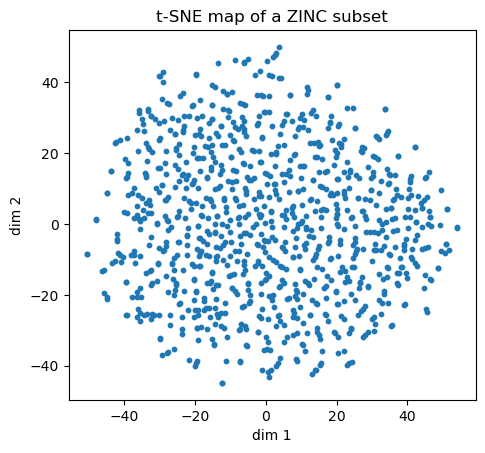

In [23]:
plt.scatter(components[:, 0], components[:, 1], s=10)
plt.gca().set_aspect('equal')
plt.title('t-SNE map of a ZINC subset')
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.show()

#TODO: na czerwono zaznacz wybrane 100 związków

**(optional) Exercise 2.2.** *(Additional ADMET filters)*

When selecting compounds, we need to consider also other properties, e.g. toxicity. Some structural patterns are well known to cause issues in terms of toxicity or synthesizability. We can quickly filter out compounds containing these patterns using their SMARTS strings ("regular expressions" for SMILES).

Use [SureChEMBL](https://www.surechembl.org/search/) to remove problematic compounds.

In [ ]:
# TODO: Use SMARTS to filter out compounds

# PubChem

[PubChem](https://pubchem.ncbi.nlm.nih.gov/) is a database of chemical information about small molecules. It contains various ADMET properties and 3D crystal structures of these molecules. You can easily find any compound using the SMILES representation or by drawing the structure in the tool on the website.

**(optional) Exercise 3.** What information can you find about your selected top compounds?

In [ ]:
#niektóre związki mogą powodować problemy przy testach biologicznych
# takie związki chcemy odfiltrować
